# Analysis of a `opsim` runs

## Juypter boilerplate

### Basic notebook configuration

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Base python modules

In [3]:
import sys
import os
from collections import namedtuple

### Standard scientific python stuff

In [4]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp

### Set plotting style

In [5]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')

use_altaz = False

### LSST specific modules

In [6]:
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'unknown'

## Configuration

Set the random number seed so the notebook is strictly repeatable:

In [7]:
np.random.seed(6563)

Paths:

In [8]:
note_dir = '/data/des70.a/data/neilsen/obs_strat/doc/seeing/note'

In [9]:
sim_db_path = '/data/des91.b/data/neilsen/LSST/devel/sims_featureScheduler_runs_1.3/seeingdb_test1'
base_results_path = '/data/des91.b/data/neilsen/LSST/opsim_runs/simsee_58779/maf_results'

In [10]:
SimSpec = namedtuple('SimSpec', ('title', 'fname'))
sims = [SimSpec('baseline v1.3', 'baseline_v1.3_10yrs'),
        SimSpec('simsee uncut 13', 'ss58777y13_v1.3_10yrs'),
        SimSpec('simsee cut 13', 'ss58779y13_v1.3_10yrs'),
        SimSpec('simsee uncut 16', 'ss58777y16_v1.3_10yrs'),
        SimSpec('simsee cut 16', 'ss58779y16_v1.3_10yrs')
       ]
sims

[SimSpec(title='baseline v1.3', fname='baseline_v1.3_10yrs'),
 SimSpec(title='simsee uncut 13', fname='ss58777y13_v1.3_10yrs'),
 SimSpec(title='simsee cut 13', fname='ss58779y13_v1.3_10yrs'),
 SimSpec(title='simsee uncut 16', fname='ss58777y16_v1.3_10yrs'),
 SimSpec(title='simsee cut 16', fname='ss58779y16_v1.3_10yrs')]

## Compare seeing histories of the new and default simulations

Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2182153 visits
Running:  ['median_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2181714 visits
Running:  ['median_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2181548 visits
Running:  ['median_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2181405 visits
Runn

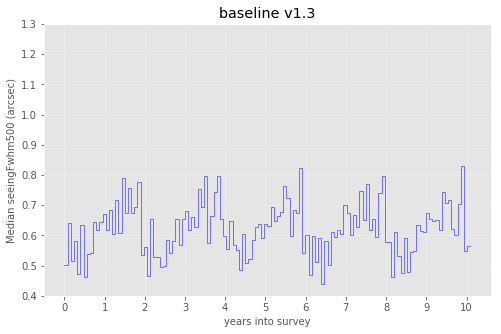

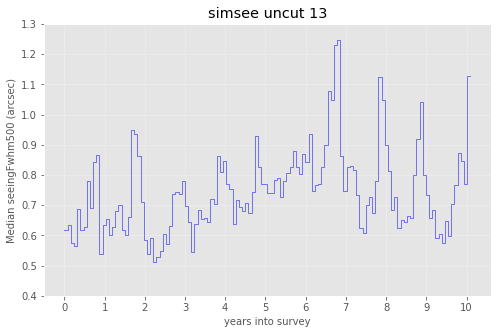

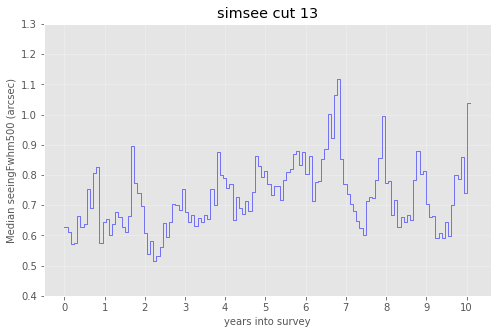

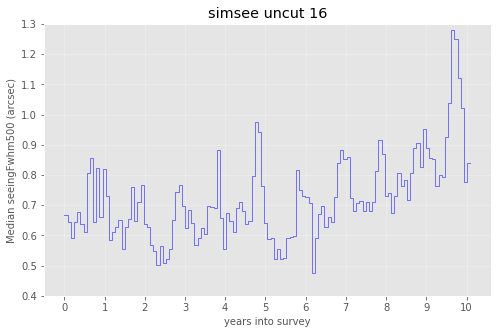

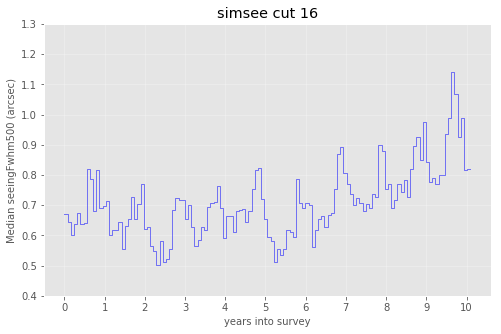

In [11]:
for sim in sims:
    sim_db_name = os.path.join(sim_db_path, sim.fname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, sim.fname)
    results_db = db.ResultsDb(outDir=results_path)

    seeing_metric = metrics.MedianMetric('seeingFwhm500')
    night_slicer = slicers.OneDSlicer('night')
    median_seeing = metricBundles.MetricBundle(seeing_metric, night_slicer)
    median_seeing_bundle = {'median_seeing': median_seeing}
    median_seeing_group = metricBundles.MetricBundleGroup(median_seeing_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    median_seeing_group.runAll()
    median_seeing_group.plotAll(closefigs=False)

    plt.ylim(0.4, 1.3)

    year_positions = np.arange(11)
    year_ticks = (np.floor(365.24*year_positions)).astype(int)
    year_labels = [str(p) for p in year_positions]
    plt.xticks(year_ticks, year_labels)
    plt.xlabel('years into survey')
    
    plt.title(sim.title)
    fig = plt.gcf()
    fig.savefig(os.path.join(note_dir, f'seeing_{sim.fname.replace(".", "_")}.png'), pdi=300, bbox_inches='tight')

## Map the seeing in the different simulations

In [12]:
def map_seeing(dbname,
               sql_constraint = 'filter = "i"',
               metric=metrics.MeanMetric):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('seeingFwhmEff')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'seeingFwhmEff': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()
    
    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.seeingFwhmEff.describe())
    
    map_plot = plots.spatialPlotters.HealpixSkyMap()
    map_plot.defaultPlotDict['colorMin'] = 0.75
    map_plot.defaultPlotDict['colorMax'] = 1.30
    if use_altaz:
        map_plot.defaultPlotDict['figsize'] = (5, 5.5)
        map_plot.healpy_visufunc = hp.azeqview
        map_plot.healpy_visufunc_params = {'rot': (0.01, -89.99, 0), 'reso': 18, 'lamb': True}
    
    metric_group.bundleDict['seeingFwhmEff'].setPlotFuncs([map_plot])
    metric_group.plotAll(closefigs=False)
    return (plt.gcf(), plt.gca())

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 470224 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470224.000000
mean          0.909407
std           0.214190
min           0.491085
25%           0.759148
50%           0.871685
75%           1.019213
max           3.367848
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i"" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 470782 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470782.000000
mean          1.046175


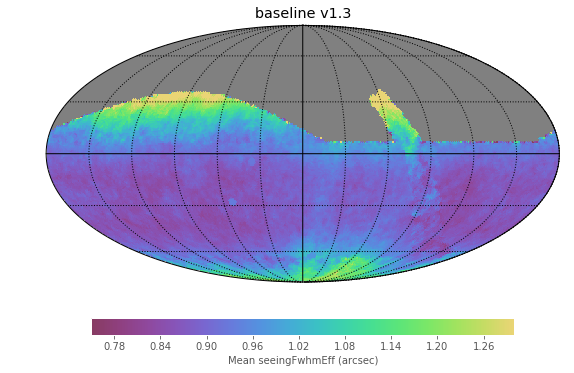

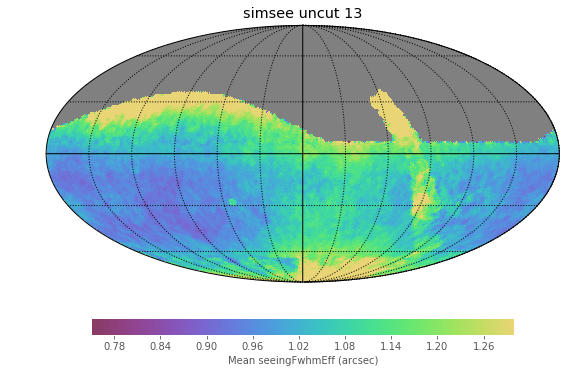

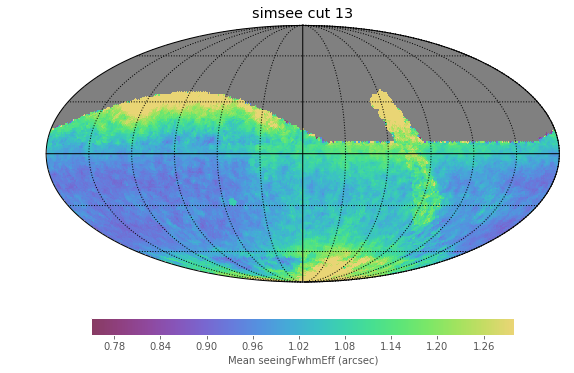

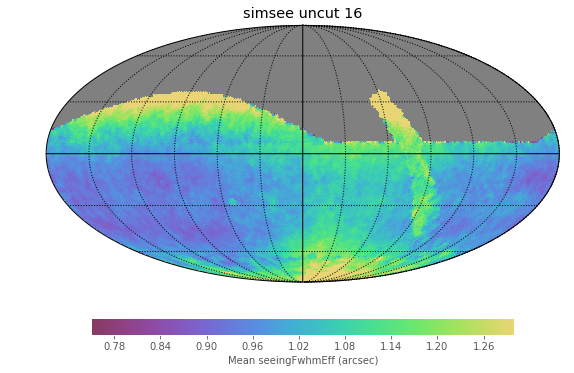

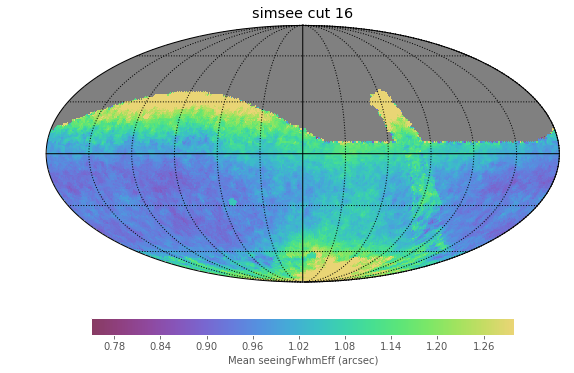

In [13]:
seeing_axes = {}
for sim in sims:
    fig, ax = map_seeing(sim.fname)
    ax.set_title(sim.title)
    fig.savefig(os.path.join(note_dir, f'seeing_map_{sim.fname.replace(".", "_")}.png'), pdi=300, bbox_inches='tight')

## Compare the depths of the different simulations

In [14]:
def map_depth(dbname,
              sql_constraint = 'filter = "i"',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('fiveSigmaDepth')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'depth': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()

    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.fiveSigmaDepth.describe())

    map_plot = plots.spatialPlotters.HealpixSkyMap()
    map_plot.defaultPlotDict['colorMin'] = 23.1
    map_plot.defaultPlotDict['colorMax'] = 23.75
    if use_altaz:
        map_plot.defaultPlotDict['figsize'] = (5, 5.5)
        map_plot.healpy_visufunc = hp.azeqview
        map_plot.healpy_visufunc_params = {'rot': (0.01, -89.99, 0), 'reso': 18, 'lamb': True}

    metric_group.bundleDict['depth'].setPlotFuncs([map_plot])
    metric_group.plotAll(closefigs=False)
    return (plt.gcf(), plt.gca())

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 470224 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470224.000000
mean         23.512494
std           0.378289
min          21.387924
25%          23.285501
50%          23.565614
75%          23.787857
max          24.426921
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i"" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 470782 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470782.000000
mean         23.395701
std          

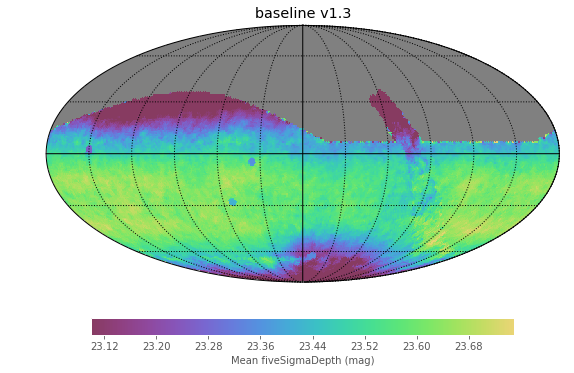

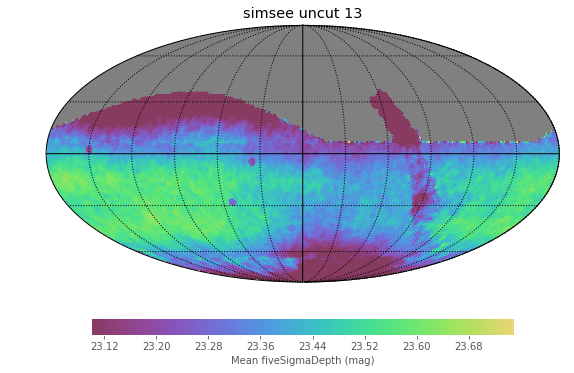

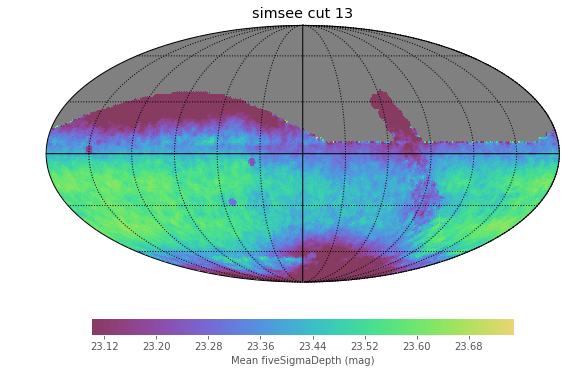

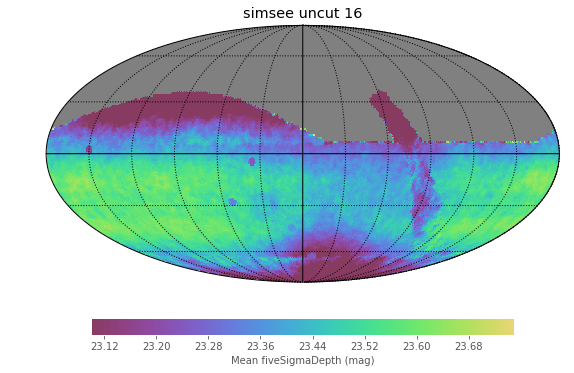

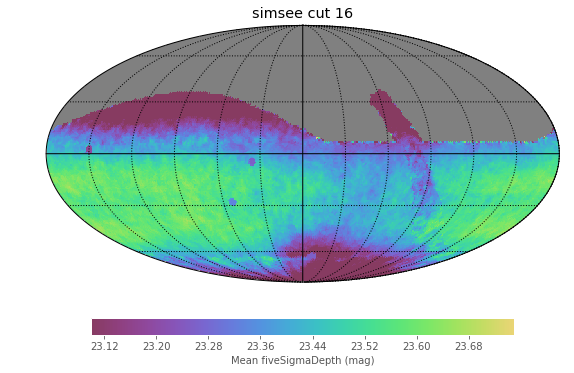

In [15]:
for sim in sims:
    fig, ax = map_depth(sim.fname)
    ax.set_title(sim.title)
    fig.savefig(os.path.join(note_dir, f'depth_map_{sim.fname.replace(".", "_")}.png'), pdi=300, bbox_inches='tight')

## Plotting depth and seeing with field R.A.

### Support code

Load data into `pandas.DataFrame`s.

In [16]:
def load_df(dbname,
            metric_columns = ['seeingFwhmEff', 'fiveSigmaDepth'],
            slice_column = 'fieldRA',
            sql_constraint = 'filter = "i" AND fieldDec<0',
            agg_metric=metrics.MeanMetric):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    slicer_for_df = slicers.OneDSlicer(slice_column)
    metric_bundle = {col: metricBundles.MetricBundle(agg_metric(col), slicer_for_df, sql_constraint)
                     for col in metric_columns}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    metric_group.runAll()
    df = pd.DataFrame.from_records(metric_group.simData)
    df.sort_values('fieldRA', inplace=True)
    df['hour'] = np.floor(df.fieldRA/15).astype(np.int32)
    return df

### Load the data

In [17]:
see_by_ra = {s.title: load_df(s.fname) for s in sims}

Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 392446 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.454523 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 392874 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.454488 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 392960 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.454525 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 392482 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.454527 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 392814 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.454515 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Plot depth against R.A.

Text(0.5, 1.0, 'fields with Decl<0°')

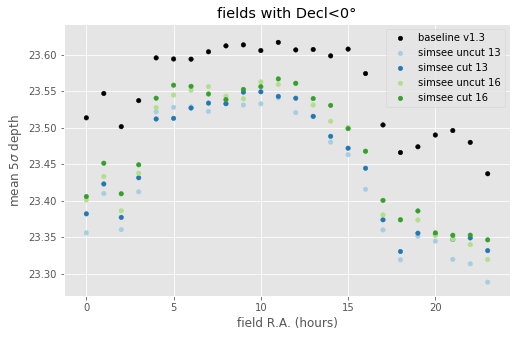

In [18]:
fig, axes = plt.subplots()
cmap = mpl.cm.get_cmap('Paired')
ncolor_in_map = 12
point_color = {sims[0].title: 'k'}
for sim_idx in np.arange(4):
    point_color[sims[sim_idx+1].title] = cmap((sim_idx+0.5)/(ncolor_in_map))
for sim in sims:
    df = see_by_ra[sim.title]
    label = sim.title
    color = [point_color[sim.title]]*24
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean 5$\sigma$ depth')
axes.set_title(u"fields with Decl<0\u00B0")

### Plot delivered FWHM against R.A.

Text(0.5, 1.0, 'fields with Decl<0°')

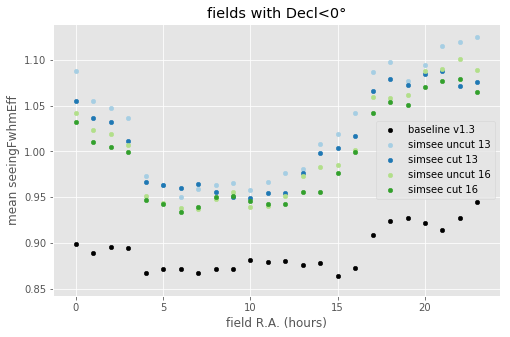

In [19]:
fig, axes = plt.subplots()
for sim in sims:
    df = see_by_ra[sim.title]
    label = sim.title
    color = point_color[sim.title]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=[color], label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean seeingFwhmEff')
axes.set_title(u"fields with Decl<0\u00B0")

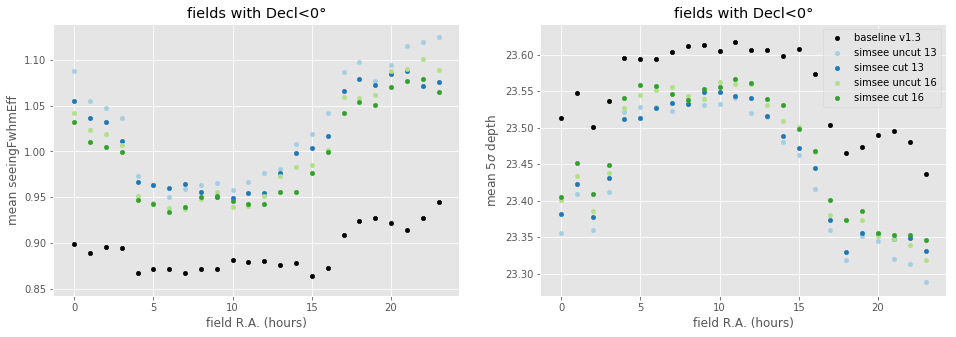

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for sim in sims:
    df = see_by_ra[sim.title]
    label = sim.title
    color = point_color[sim.title]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=[color], label=label, ax=axes[0])
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=[color], label=label, ax=axes[1])

axes[0].set_xlabel('field R.A. (hours)')
axes[0].set_ylabel('mean seeingFwhmEff')
axes[0].set_title(u"fields with Decl<0\u00B0")

axes[1].set_xlabel('field R.A. (hours)')
axes[1].set_ylabel('mean 5$\sigma$ depth')
axes[1].set_title(u"fields with Decl<0\u00B0")

axes[0].get_legend().remove()
fig.savefig(os.path.join(note_dir, 'seeing_depth_by_ra.png'), pdi=300, bbox_inches='tight')


In [22]:
see_by_ra[sim.title].head()

,seeingFwhmEff,fiveSigmaDepth,fieldRA,hour
302309,1.042342,23.479239,0.001498,0
306166,1.643056,23.081881,0.002841,0
237665,0.833917,23.167643,0.004415,0
387176,0.817670,23.806753,0.005448,0
186508,0.962705,23.238248,0.006297,0


In [49]:
bl = see_by_ra[sims[0].title].groupby('hour')['seeingFwhmEff', 'fiveSigmaDepth'].mean()

cols = ['seeingFwhmEff', 'fiveSigmaDepth']
lims = {c: {'max': [], 'min': []} for c in cols}

for sim in sims[1:]:
    df = see_by_ra[sim.title].groupby('hour')[cols].mean()        
    for col in cols:
        difference = (df[col]-bl[col])/bl[col] if col=='seeingFwhmEff' else (bl[col]-df[col])
        lims[col]['max'].append(difference.max())
        lims[col]['min'].append(difference.min())
        
result = pd.DataFrame({}, index=[s.title for s in sims[1:]])
for col in cols:
    for s in 'min', 'max':
        result['_'.join((s, col))] = lims[col][s]
result.sort_index()

,min_seeingFwhmEff,max_seeingFwhmEff,min_fiveSigmaDepth,max_fiveSigmaDepth
simsee cut 13,0.076966,0.190126,0.056486,0.149036
simsee cut 16,0.071204,0.178770,0.035839,0.143251
simsee uncut 13,0.087271,0.221176,0.065334,0.176236
simsee uncut 16,0.065245,0.192919,0.042444,0.148837


In [59]:
cols = ['seeingFwhmEff', 'fiveSigmaDepth']
lims = {c: [] for c in cols}

for sim in sims:
    df = see_by_ra[sim.title].groupby('hour')[cols].mean()        
    for col in cols:
        mean_value = df[col].mean()
        difference = (df[col]-mean_value)/mean_value if col=='seeingFwhmEff' else (mean_value-df[col])
        lims[col].append(difference.rolling(window=6).mean().max()-difference.rolling(window=6).mean().min())
        
result = pd.DataFrame({}, index=[s.title for s in sims])
for col in cols:
        result[col] = lims[col]
result.sort_index()

,seeingFwhmEff,fiveSigmaDepth
baseline v1.3,0.063297,0.136380
simsee cut 13,0.122165,0.196539
simsee cut 16,0.123039,0.192067
simsee uncut 13,0.140857,0.208359
simsee uncut 16,0.137593,0.202379
